<center>
    <img src="https://gitlab.com/ibm/skills-network/courses/placeholder101/-/raw/master/labs/module%201/images/IDSNlogo.png" width="300" alt="cognitiveclass.ai logo"  />
</center>


# **Space X  Falcon 9 First Stage Landing Prediction**


## Assignment:  Machine Learning Prediction


Estimated time needed: **60** minutes


Space X advertises Falcon 9 rocket launches on its website with a cost of 62 million dollars; other providers cost upward of 165 million dollars each, much of the savings is because Space X can reuse the first stage. Therefore if we can determine if the first stage will land, we can determine the cost of a launch. This information can be used if an alternate company wants to bid against space X for a rocket launch.   In this lab, you will create a machine learning pipeline  to predict if the first stage will land given the data from the preceding labs.


![](https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/IBMDeveloperSkillsNetwork-DS0701EN-SkillsNetwork/api/Images/landing\_1.gif)


Several examples of an unsuccessful landing are shown here:


![](https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/IBMDeveloperSkillsNetwork-DS0701EN-SkillsNetwork/api/Images/crash.gif)


Most unsuccessful landings are planed. Space X; performs a controlled landing in the oceans.


## Objectives


Perform exploratory  Data Analysis and determine Training Labels

*   create a column for the class
*   Standardize the data
*   Split into training data and test data

\-Find best Hyperparameter for SVM, Classification Trees and Logistic Regression

*   Find the method performs best using test data


***


## Import Libraries and Define Auxiliary Functions


We will import the following libraries for the lab


In [2]:
# ── Core libraries ──
import pandas as pd   # Data manipulation and analysis
import numpy as np    # Support for arrays, matrices, and mathematical functions

# ── Visualization libraries ──
import matplotlib.pyplot as plt   # Plotting library with MATLAB-like interface
import seaborn as sns             # Statistical data visualization based on matplotlib

# ── Scikit-learn utilities ──
from sklearn import preprocessing                     # Data preprocessing and standardization
from sklearn.model_selection import train_test_split  # Split dataset into train and test sets
from sklearn.model_selection import GridSearchCV      # Hyperparameter tuning

# ── Classification algorithms ──
from sklearn.linear_model import LogisticRegression   # Logistic Regression
from sklearn.svm import SVC                           # Support Vector Machine
from sklearn.tree import DecisionTreeClassifier       # Decision Tree
from sklearn.neighbors import KNeighborsClassifier    # K-Nearest Neighbors

This function is to plot the confusion matrix.


In [3]:
# ── Function to plot confusion matrix ──
def plot_confusion_matrix(y, y_predict):
    """
    Plot the confusion matrix using seaborn heatmap.
    
    Parameters:
    y (array-like): True labels
    y_predict (array-like): Predicted labels
    """
    from sklearn.metrics import confusion_matrix
    
    # Compute confusion matrix
    cm = confusion_matrix(y, y_predict)
    
    # Create heatmap
    ax = plt.subplot()
    sns.heatmap(cm, annot=True, ax=ax)  # annot=True to annotate cells
    
    # Set axis labels and title
    ax.set_xlabel('Predicted labels')
    ax.set_ylabel('True labels')
    ax.set_title('Confusion Matrix')
    
    # Customize tick labels
    ax.xaxis.set_ticklabels(['did not land', 'land'])
    ax.yaxis.set_ticklabels(['did not land', 'landed'])


## Load the dataframe


Load the data


In [4]:
# ── Load dataset ──
data = pd.read_csv(
    "https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/"
    "IBM-DS0321EN-SkillsNetwork/datasets/dataset_part_2.csv"
)

# ── Preview dataset ──
data.head()

,FlightNumber,Date,BoosterVersion,PayloadMass,Orbit,LaunchSite,Outcome,Flights,GridFins,Reused,Legs,LandingPad,Block,ReusedCount,Serial,Longitude,Latitude,Class
0,1,2010-06-04,Falcon 9,6104.959412,LEO,CCAFS SLC 40,None None,1,False,False,False,NaN,1.0,0,B0003,-80.577366,28.561857,0
1,2,2012-05-22,Falcon 9,525.000000,LEO,CCAFS SLC 40,None None,1,False,False,False,NaN,1.0,0,B0005,-80.577366,28.561857,0
2,3,2013-03-01,Falcon 9,677.000000,ISS,CCAFS SLC 40,None None,1,False,False,False,NaN,1.0,0,B0007,-80.577366,28.561857,0
3,4,2013-09-29,Falcon 9,500.000000,PO,VAFB SLC 4E,False Ocean,1,False,False,False,NaN,1.0,0,B1003,-120.610829,34.632093,0
4,5,2013-12-03,Falcon 9,3170.000000,GTO,CCAFS SLC 40,None None,1,False,False,False,NaN,1.0,0,B1004,-80.577366,28.561857,0


In [5]:
# ── Load dataset ──
X = pd.read_csv(
    "https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/"
    "IBM-DS0321EN-SkillsNetwork/datasets/dataset_part_3.csv"
)

# ── Preview first 100 rows ──
X.head(100)

,FlightNumber,PayloadMass,Flights,Block,ReusedCount,Orbit_ES-L1,Orbit_GEO,Orbit_GTO,Orbit_HEO,Orbit_ISS,...,Serial_B1058,Serial_B1059,Serial_B1060,Serial_B1062,GridFins_False,GridFins_True,Reused_False,Reused_True,Legs_False,Legs_True
0,1.0,6104.959412,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0
1,2.0,525.000000,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0
2,3.0,677.000000,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0
3,4.0,500.000000,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0
4,5.0,3170.000000,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
85,86.0,15400.000000,2.0,5.0,2.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0
86,87.0,15400.000000,3.0,5.0,2.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0
87,88.0,15400.000000,6.0,5.0,5.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0
88,89.0,15400.000000,3.0,5.0,2.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0


## TASK  1


Create a NumPy array from the column <code>Class</code> in <code>data</code>, by applying the method <code>to_numpy()</code>  then
assign it  to the variable <code>Y</code>,make sure the output is a  Pandas series (only one bracket df\['name of  column']).


In [6]:
# ── Define target variable ──
Y = data['Class'].to_numpy()

## TASK  2


Standardize the data in <code>X</code> then reassign it to the variable  <code>X</code> using the transform provided below.


In [7]:
# ── Initialize standard scaler ──
transform = preprocessing.StandardScaler()

In [8]:
# ── Apply standard scaling to features ──
X = transform.fit(X).transform(X)

We split the data into training and testing data using the  function  <code>train_test_split</code>.   The training data is divided into validation data, a second set used for training  data; then the models are trained and hyperparameters are selected using the function <code>GridSearchCV</code>.


## TASK  3


Use the function train_test_split to split the data X and Y into training and test data. Set the parameter test_size to  0.2 and random_state to 2. The training data and test data should be assigned to the following labels.


<code>X_train, X_test, Y_train, Y_test</code>


In [9]:
# ── Split dataset into training and testing sets ──
X_train, X_test, Y_train, Y_test = train_test_split(
    X, Y, test_size=0.2, random_state=2
)

we can see we only have 18 test samples.


In [10]:
# ── Check shape of test target set ──
Y_test.shape

(18,)

## TASK  4


Create a logistic regression object  then create a  GridSearchCV object  <code>logreg_cv</code> with cv = 10.  Fit the object to find the best parameters from the dictionary <code>parameters</code>.


In [11]:
# ── Define hyperparameters for Logistic Regression ──
parameters = {
    'C': [0.01, 0.1, 1],
    'penalty': ['l2'],
    'solver': ['lbfgs']
}

In [12]:
# ── Define hyperparameters for Logistic Regression ──
parameters = {
    "C": [0.01, 0.1, 1],          # Regularization strength
    "penalty": ["l2"],            # l1 = Lasso, l2 = Ridge
    "solver": ["lbfgs"]           # Optimization algorithm
}

# ── Initialize Logistic Regression model ──
lr = LogisticRegression()

# ── Perform GridSearchCV with 10-fold cross-validation ──
logreg_cv = GridSearchCV(lr, parameters, scoring='accuracy', cv=10)

# ── Fit model on training data ──
logreg_cv = logreg_cv.fit(X_train, Y_train)

We output the <code>GridSearchCV</code> object for logistic regression. We display the best parameters using the data attribute <code>best_params\_</code> and the accuracy on the validation data using the data attribute <code>best_score\_</code>.


In [13]:
# ── Display best parameters and accuracy ──
print("Tuned hyperparameters (best parameters):", logreg_cv.best_params_)
print("Accuracy:", logreg_cv.best_score_)

Tuned hyperparameters (best parameters): {'C': 0.01, 'penalty': 'l2', 'solver': 'lbfgs'}
Accuracy: 0.8464285714285713


## TASK  5


Calculate the accuracy on the test data using the method <code>score</code>:


In [16]:
# ── Evaluate Logistic Regression on test set ──
lr_accuracy = logreg_cv.score(X_test, Y_test)
round(lr_accuracy, 3)

0.833

Lets look at the confusion matrix:


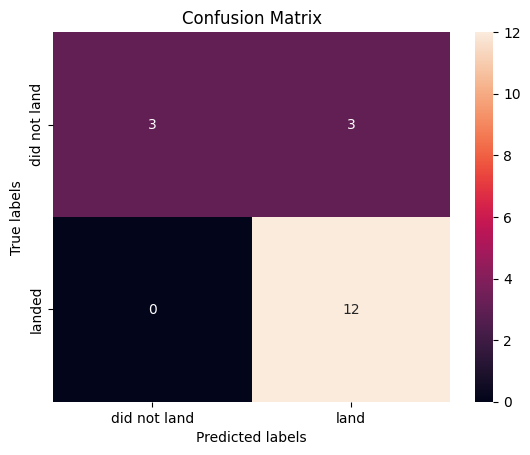

In [17]:
# ── Generate predictions and plot confusion matrix ──
yhat = logreg_cv.predict(X_test)
plot_confusion_matrix(Y_test, yhat)

Examining the confusion matrix, we see that logistic regression can distinguish between the different classes.  We see that the major problem is false positives.


## TASK  6


Create a support vector machine object then  create a  <code>GridSearchCV</code> object  <code>svm_cv</code> with cv - 10.  Fit the object to find the best parameters from the dictionary <code>parameters</code>.


In [18]:
# ── Define hyperparameters for Support Vector Machine ──
parameters = {
    'kernel': ('linear', 'rbf', 'poly', 'sigmoid'),  # Kernel functions
    'C': np.logspace(-3, 3, 5),                      # Regularization parameter
    'gamma': np.logspace(-3, 3, 5)                   # Kernel coefficient
}

# ── Initialize SVM classifier ──
svm = SVC()

In [19]:
# ── Perform GridSearchCV for SVM with 10-fold cross-validation ──
svm_cv = GridSearchCV(svm, parameters, scoring='accuracy', cv=10)

# ── Fit model on training data ──
svm_cv = svm_cv.fit(X_train, Y_train)

In [20]:
# ── Display best parameters and accuracy for SVM ──
print("Tuned hyperparameters (best parameters):", svm_cv.best_params_)
print("Accuracy:", svm_cv.best_score_)

Tuned hyperparameters (best parameters): {'C': np.float64(1.0), 'gamma': np.float64(0.03162277660168379), 'kernel': 'sigmoid'}
Accuracy: 0.8482142857142856


## TASK  7


Calculate the accuracy on the test data using the method <code>score</code>:


In [23]:
# ── Evaluate SVM on test set ──
svm_accuracy = svm_cv.score(X_test, Y_test)
round(svm_accuracy, 3)

0.833

We can plot the confusion matrix


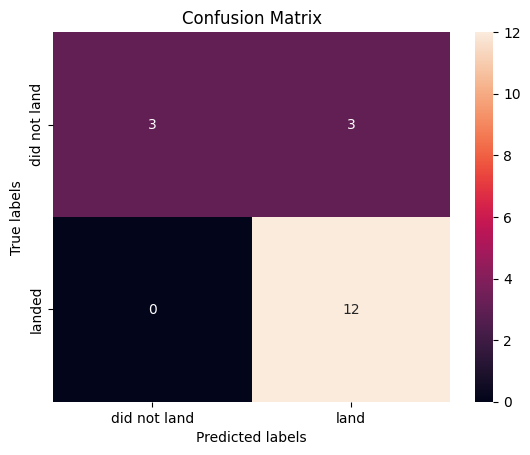

In [24]:
# ── Generate predictions with SVM and plot confusion matrix ──
yhat = svm_cv.predict(X_test)
plot_confusion_matrix(Y_test, yhat)

## TASK  8


Create a decision tree classifier object then  create a  <code>GridSearchCV</code> object  <code>tree_cv</code> with cv = 10.  Fit the object to find the best parameters from the dictionary <code>parameters</code>.


In [ ]:
# ── Define hyperparameters for Decision Tree (fixed) ──
parameters = {
    'criterion': ['gini', 'entropy'],
    'splitter': ['best', 'random'],
    'max_depth': [2 * n for n in range(1, 10)],
    'max_features': ['sqrt', 'log2', None],   # 'auto' removed
    'min_samples_leaf': [1, 2, 4],
    'min_samples_split': [2, 5, 10]
}

# ── Initialize Decision Tree classifier ──
tree = DecisionTreeClassifier()

# ── Perform GridSearchCV with 10-fold cross-validation ──
tree_cv = GridSearchCV(tree, parameters, scoring='accuracy', cv=10)
tree_cv = tree_cv.fit(X_train, Y_train)


In [28]:
print("tuned hpyerparameters :(best parameters) ",tree_cv.best_params_)
print("accuracy :",tree_cv.best_score_)

tuned hpyerparameters :(best parameters)  {'criterion': 'entropy', 'max_depth': 4, 'max_features': 'sqrt', 'min_samples_leaf': 2, 'min_samples_split': 5, 'splitter': 'random'}
accuracy : 0.875


## TASK  9


Calculate the accuracy of tree_cv on the test data using the method <code>score</code>:


In [30]:
# ── Evaluate Decision Tree on test set ──
tree_accuracy = tree_cv.score(X_test, Y_test)
round(tree_accuracy, 3)

0.833

We can plot the confusion matrix


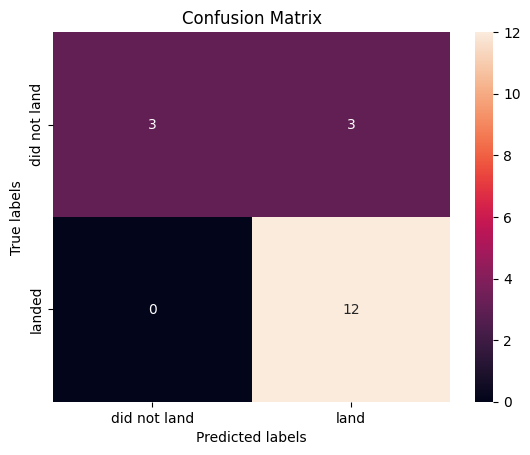

In [ ]:
# ── Generate predictions with SVM and plot confusion matrix ──
yhat = tree_accuracy.predict(X_test)
plot_confusion_matrix(Y_test, yhat)

## TASK  10


Create a k nearest neighbors object then  create a  <code>GridSearchCV</code> object  <code>knn_cv</code> with cv = 10.  Fit the object to find the best parameters from the dictionary <code>parameters</code>.


In [32]:
# ── Define hyperparameters for K-Nearest Neighbors ──
parameters = {
    'n_neighbors': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10],   # Number of neighbors
    'algorithm': ['auto', 'ball_tree', 'kd_tree', 'brute'],  # Search algorithm
    'p': [1, 2]  # Distance metric (1 = Manhattan, 2 = Euclidean)
}

# ── Initialize KNN classifier ──
KNN = KNeighborsClassifier()

In [33]:
# ── Perform GridSearchCV for KNN with 10-fold cross-validation ──
knn_cv = GridSearchCV(KNN, parameters, scoring='accuracy', cv=10)

# ── Fit model on training data ──
knn_cv = knn_cv.fit(X_train, Y_train)

In [35]:
# ── Display best parameters and accuracy for KNN ──
print("Tuned hyperparameters (best parameters):", knn_cv.best_params_)
print("Accuracy:", round(knn_cv.best_score_, 3))

Tuned hyperparameters (best parameters): {'algorithm': 'auto', 'n_neighbors': 10, 'p': 1}
Accuracy: 0.848


## TASK  11


Calculate the accuracy of tree_cv on the test data using the method <code>score</code>:


In [37]:
# ── Evaluate KNN on test set ──
knn_accuracy = knn_cv.score(X_test, Y_test)
round(knn_accuracy, 3)

0.833

We can plot the confusion matrix


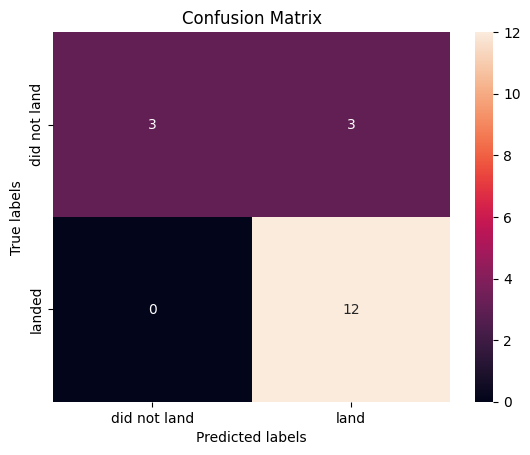

In [38]:
# ── Generate predictions with KNN and plot confusion matrix ──
yhat = knn_cv.predict(X_test)
plot_confusion_matrix(Y_test, yhat)

## TASK  12


Find the method performs best:


In [39]:
# ── Compare best cross-validation scores of all models ──
algo_score = {
    'Logistic Regression': [logreg_cv.best_score_],
    'SVM': [svm_cv.best_score_],
    'Decision Tree': [tree_cv.best_score_],
    'KNN': [knn_cv.best_score_]
}

# ── Create DataFrame with best scores ──
df = pd.DataFrame.from_dict(algo_score, orient='index', columns=['Best scores'])
df.head()


,Best scores
Logistic Regression,0.846429
SVM,0.848214
Decision Tree,0.875000
KNN,0.848214


In [40]:
# ── Identify best model based on highest score ──
best_method = df['Best scores'].idxmax()

print("The best method is:", best_method)

The best method is: Decision Tree


## Authors


<a href="https://www.linkedin.com/in/joseph-s-50398b136/?utm_medium=Exinfluencer&utm_source=Exinfluencer&utm_content=000026UJ&utm_term=10006555&utm_id=NA-SkillsNetwork-Channel-SkillsNetworkCoursesIBMDS0321ENSkillsNetwork26802033-2021-01-01">Joseph Santarcangelo</a> has a PhD in Electrical Engineering, his research focused on using machine learning, signal processing, and computer vision to determine how videos impact human cognition. Joseph has been working for IBM since he completed his PhD.


## Change Log


| Date (YYYY-MM-DD) | Version | Changed By    | Change Description      |
| ----------------- | ------- | ------------- | ----------------------- |
| 2021-08-31        | 1.1     | Lakshmi Holla | Modified markdown       |
| 2020-09-20        | 1.0     | Joseph        | Modified Multiple Areas |


Copyright © 2020 IBM Corporation. All rights reserved.
